In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import FashionMNIST, CIFAR10
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from itertools import product
import ast
import time
import numpy as np

In [11]:
# Define normalization for Fashion MNIST (Grayscale, 1 channel)
transform_fashion_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Define normalization for CIFAR-10 (RGB, 3 channels)
transform_cifar10 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load the Fashion MNIST training data
fashion_mnist_train = FashionMNIST(root='./data', train=True, download=True, transform=transform_fashion_mnist)
fashion_mnist_test = FashionMNIST(root='./data', train=False, download=True, transform=transform_fashion_mnist)

# Download and load the CIFAR-10 training data
cifar10_train = CIFAR10(root='./data', train=True, download=True, transform=transform_cifar10)
cifar10_test = CIFAR10(root='./data', train=False, download=True, transform=transform_cifar10)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
print(f"Number of training images in Fashion MNIST: {len(fashion_mnist_train )}")
print(f"Number of test images in Fashion MNIST: {len(fashion_mnist_test)}")
print(f"Number of training images in CIFAR-10: {len(cifar10_train)}")
print(f"Number of test images in CIFAR-10: {len(cifar10_test)}")

Number of training images in Fashion MNIST: 60000
Number of test images in Fashion MNIST: 10000
Number of training images in CIFAR-10: 50000
Number of test images in CIFAR-10: 10000


Fashion MNIST Samples:


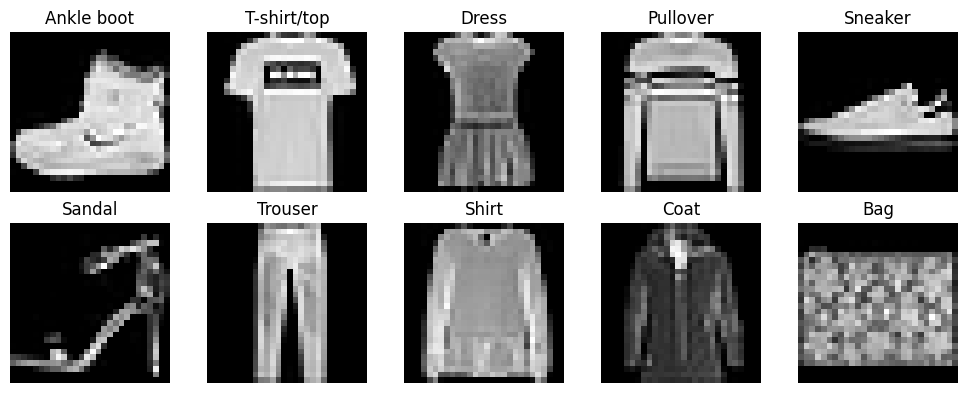


CIFAR-10 Samples:


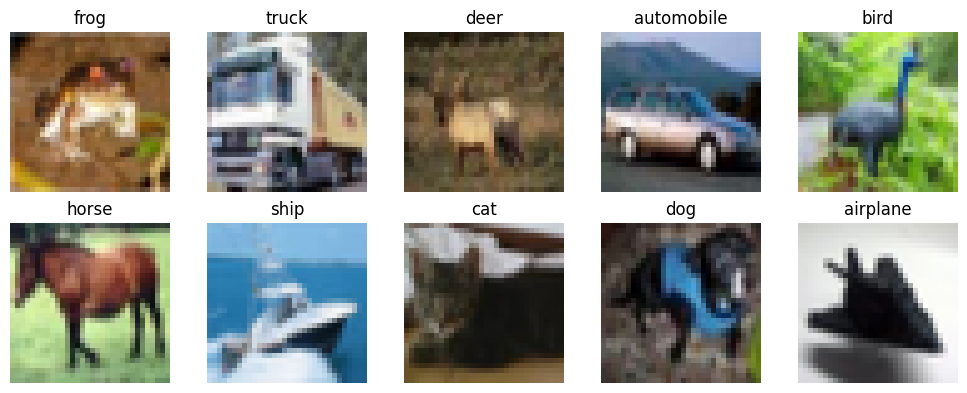

In [ ]:
# Function to unnormalize and display images
def imshow(img, normalize_channels):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()

    # Adjust channel positions based on normalization
    if len(normalize_channels) == 1:  # Grayscale
        plt.imshow(npimg[0], cmap='gray')
    else:  # RGB
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def display_samples_from_dataset(dataset, normalize_channels):
    # Dictionary to keep track of the first occurrence of each class
    class_images = {}

    for image, label in dataset:
        if label not in class_images:
            class_images[label] = image
        if len(class_images) == len(dataset.classes):
            break

    # Plotting the images
    rows = 2
    cols = len(dataset.classes) // rows
    fig = plt.figure(figsize=(cols*2, rows*2))
    for idx, (label, img) in enumerate(class_images.items()):
        ax = fig.add_subplot(rows, cols, idx + 1)
        imshow(img, normalize_channels)
        ax.set_title(dataset.classes[label])
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Display samples from Fashion MNIST
print("Fashion MNIST Samples:")
display_samples_from_dataset(fashion_mnist_train, (0.5,))

# Display samples from CIFAR-10
print("\nCIFAR-10 Samples:")
display_samples_from_dataset(cifar10_train, (0.5, 0.5, 0.5))

In [12]:
# This function will split a dataset into training and test sets.
def train_test_split(X, y, test_ratio=0.2, random_seed=42):
    # Setting the random seed ensures reproducibility of results.
    np.random.seed(random_seed)

    # m stores the total number of samples (columns) in the dataset.
    m = X.shape[1]

    # Generating a permutation of indices so we can shuffle the dataset.
    indices = np.random.permutation(m)

    # Determining the number of test samples based on the specified ratio.
    test_size = int(test_ratio * m)

    # Splitting the permuted indices into test and train sets.
    test_indices = indices[:test_size]
    train_indices = indices[test_size:]

    # Using the indices to select the data samples for train and test sets.
    X_train, y_train = X[:, train_indices], y[:, train_indices]
    X_test, y_test = X[:, test_indices], y[:, test_indices]

    # Returning the split datasets.
    return X_train, y_train, X_test, y_test


# Converting the dataset to a numpy array and reshaping it to have each sample as a column.
X_fashion = fashion_mnist_train.data.numpy().reshape(-1, 28*28).T

# One-hot encoding the target labels.
y_fashion = np.eye(10)[np.array(fashion_mnist_train.targets)].T

# Splitting the prepared Fashion MNIST dataset into training and test sets.
X_fashion_train, y_fashion_train, X_fashion_test, y_fashion_test = train_test_split(X_fashion, y_fashion)

# Reshaping the CIFAR-10 dataset to have each sample as a column.
X_cifar = cifar10_train.data.reshape(-1, 32*32*3).T

# Again, one-hot encoding the target labels.
y_cifar = np.eye(10)[np.array(cifar10_train.targets)].T

# Splitting the prepared CIFAR-10 dataset into training and test sets.
X_cifar_train, y_cifar_train, X_cifar_test, y_cifar_test = train_test_split(X_cifar, y_cifar)

In [13]:
@staticmethod
def softmax(z):
    # Subtracting the max for numerical stability, as large numbers can cause numerical issues with exp().
    z = z - np.max(z, axis=0, keepdims=True)
    e_z = np.exp(z)
    # Softmax formula: taking the exponential of each element and normalizing by the sum of exponentials.
    return e_z / e_z.sum(axis=0, keepdims=True)

@staticmethod
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

@staticmethod
def sigmoid_derivative(z):
    s = 1.0 / (1.0 + np.exp(-z))
    return s * (1 - s)

@staticmethod
def tanh_activation(x):
    return np.tanh(x)

@staticmethod
def tanh_derivative(x):
    return 1 - np.tanh(x)**2

@staticmethod
def relu(x):
    # ReLU (Rectified Linear Unit) activation: All negative values become 0, positives stay the same.
    return np.maximum(0, x)

@staticmethod
def relu_derivative(z):
    # Derivative of ReLU. If z > 0, derivative is 1, otherwise it's 0.
    return np.where(z > 0, 1, 0)

@staticmethod
def leaky_relu(x, gamma=0.01):
    # Leaky ReLU activation: Similar to ReLU but allows small negative values.
    return np.maximum(0, x) + gamma * np.minimum(0, x)

@staticmethod
def leaky_relu_derivative(x, gamma=0.01):
    # Derivative of Leaky ReLU. If x > 0, derivative is 1, otherwise it's gamma.
    return np.where(x > 0, 1, gamma)

@staticmethod
def softplus(x):
    # Softplus activation: Smooth version of ReLU. Doesn't sharply cut off at 0.
    return np.log(1 + np.exp(x))

@staticmethod
def softplus_derivative(x):
    # Derivative of Softplus. Interestingly, it's just the sigmoid function.
    return 1.0 / (1.0 + np.exp(-x))

@staticmethod
def l1_regularization(weights, lambda_):
    # L1 regularization: Adds penalty based on absolute value of weights. Helps prevent overfitting.
    return lambda_ * np.sum(np.abs(weights))

@staticmethod
def l2_regularization(weights, lambda_):
    # L2 regularization: Adds penalty based on square of weights. Another way to prevent overfitting.
    return lambda_ * np.sum(weights ** 2)

@staticmethod
def add_noise(data, noise_level):
    # Adding Gaussian noise to data. Useful for techniques like data augmentation.
    noise = np.random.normal(0, noise_level, data.shape)
    return data + noise

@staticmethod
def dropout(layer, dropout_rate):
    # Dropout: A form of regularization where random neurons are "dropped" or turned off during training.
    mask = np.random.binomial(1, 1 - dropout_rate, size=layer.shape)
    return layer * mask

@staticmethod
def adjust_learning_rate(lr, epoch, decay_rate):
    # Gradually reduces the learning rate over time (epochs). Helps improve convergence in training.
    return lr * (1 / (1 + decay_rate * epoch))

@staticmethod
def cross_entropy_loss(y_pred, y_true):
    m = y_true.shape[1]
    # Tiny value to prevent log(0) which is undefined.
    regularization = 1e-10
    # Cross-entropy loss: A common loss function for classification tasks.
    loss = -1/m * np.sum(y_true * np.log(y_pred + regularization))
    return loss

class MLP:
    def __init__(self, input_dim, hidden_layers, activation_fn='sigmoid', initialization="kaiming", use_bn=False, dropout_rate=0.0):
        # Whether to use Batch Normalization.
        self.use_bn = use_bn

        # Activation function for the neurons ('sigmoid', 'relu', etc.).
        self.activation_fn = activation_fn

        # Dropout rate for regularization. 0 means no dropout.
        self.dropout_rate = dropout_rate

        # These lists will store parameters for Batch Normalization if it's enabled.
        self.gammas = []
        self.betas = []

        # Running means and variances for each layer for Batch Normalization.
        self.running_means = [np.zeros((l, 1)) for l in hidden_layers]
        self.running_vars = [np.zeros((l, 1)) for l in hidden_layers]

        # Momentum factor for updating running statistics in Batch Normalization.
        self.momentum = 0.9

        # Number of classes in the output layer, assuming a classification task.
        self.output_dim = 10

        # If Batch Normalization is enabled, initialize gamma (scale) and beta (shift) for each layer.
        if use_bn:
            for l in hidden_layers[:-1]:
                self.gammas.append(np.ones(l))
                self.betas.append(np.zeros(l))

        # List to store the loss values as the model trains.
        self.loss_history = []

        # Initialize the weights and biases of the neural network.
        self.weights, self.biases = self.initialize_weights([input_dim] + hidden_layers + [self.output_dim], initialization)

    @staticmethod
    def initialize_weights(layers, initialization="kaiming"):
        weights = []
        biases = []

        # Loop through each layer to initialize its weights and biases.
        for i in range(len(layers) - 1):
            # Different initialization strategies:
            # zeros: all weights are initialized to zero (not recommended in practice).
            if initialization == "zeros":
                weights.append(np.zeros((layers[i+1], layers[i])))

            # uniform: weights are initialized uniformly between -1 and 1.
            elif initialization == "uniform":
                weights.append(np.random.uniform(-1, 1, (layers[i+1], layers[i])))

            # gaussian: weights are initialized according to a standard Gaussian distribution.
            elif initialization == "gaussian":
                weights.append(np.random.randn(layers[i+1], layers[i]))

            # xavier: considers the size of the previous layer.
            elif initialization == "xavier":
                weights.append(np.random.randn(layers[i+1], layers[i]) * np.sqrt(1. / layers[i]))

            # kaiming: considers the size of the previous layer. Good for ReLU activations.
            elif initialization == "kaiming":
                weights.append(np.random.randn(layers[i+1], layers[i]) * np.sqrt(2. / layers[i]))

            else:
                raise ValueError(f"Initialization method {initialization} not recognized")

            # Initialize biases for the current layer as Gaussian random values.
            biases.append(np.random.randn(layers[i+1], 1))

        return weights, biases

    def batchnorm_forward(self, x, gamma, beta, layer_idx, training=True, eps=1e-5):
        N, D = x.shape  # N: number of samples, D: dimensions of each sample.

        if training:
            # Compute mean and variance of the current batch.
            sample_mean = np.mean(x, axis=1, keepdims=True)
            sample_var = np.var(x, axis=1, keepdims=True)

            # Update the moving averages of mean and variance using momentum.
            self.running_means[layer_idx] = self.momentum * self.running_means[layer_idx] + (1 - self.momentum) * sample_mean.squeeze()
            self.running_vars[layer_idx] = self.momentum * self.running_vars[layer_idx] + (1 - self.momentum) * sample_var.squeeze()

            # Normalize the batch data (subtract mean, divide by standard deviation).
            x_centered = x - sample_mean
            std = np.sqrt(sample_var + eps)  # Add a small epsilon for numerical stability.
            x_norm = x_centered / std

            # Scale and shift the normalized data.
            out = gamma[:, None] * x_norm + beta[:, None]

            mean = sample_mean
            var = sample_var

        else:
            # If not training, normalize using the running means and variances.
            x_centered = x - self.running_means[layer_idx].reshape(-1, 1)
            std = np.sqrt(self.running_vars[layer_idx] + eps).reshape(-1, 1)
            x_norm = x_centered / std
            out = gamma * x_norm + beta

            mean = self.running_means[layer_idx]
            var = self.running_vars[layer_idx]

        # Store intermediate values needed for backpropagation.
        cache = (x, x_norm, mean, var, eps)
        return out, cache

    @staticmethod
    def batchnorm_backward(dout, cache, gamma, beta):
        # Retrieve cached values.
        x, x_norm, mean, var, eps = cache

        N, D = dout.shape

        # Compute the gradient of the loss with respect to beta.
        dbeta = np.sum(dout, axis=1)

        # Compute the gradient of the loss with respect to gamma.
        dgamma = np.sum(dout * x_norm, axis=1)

        # Gradient with respect to the normalized data.
        dx_norm = dout * gamma[:, None]

        # Gradient with respect to variance.
        dvar = np.sum(dx_norm * (x - mean) * (-0.5) * np.power(var + eps, -1.5), axis=0)

        # Gradient with respect to mean.
        dmean = np.sum(dx_norm * (-1 / np.sqrt(var + eps)), axis=0)
        dmean += dvar * np.sum(-2 * (x - mean), axis=0) / N

        # Gradient with respect to the original data.
        dx = dx_norm / np.sqrt(var + eps)
        dx += dvar * 2 * (x - mean) / N
        dx += dmean / N

        return dx, dgamma, dbeta

    def _forward(self, x, training=True):
        # Lists to store activations and pre-activations at each layer.
        activations = [x]
        pre_activations = []
        bn_caches = []  # Store batch normalization caches

        # Loop through all the layers except the output layer.
        for i, (w, b) in enumerate(zip(self.weights[:-1], self.biases[:-1])):

            # Compute pre-activation value.
            z = np.dot(w, activations[-1]) + b

            # If we're using batch normalization and it's not the input or last layer.
            if self.use_bn and i < len(self.weights) - 2 and training:
                gamma = self.gammas[i]
                beta = self.betas[i]
                z, cache = self.batchnorm_forward(z, gamma, beta, i, training=training)
                bn_caches.append(cache)

            # Save pre-activation for later.
            pre_activations.append(z)

            # Apply the chosen activation function.
            if self.activation_fn == 'sigmoid':
                activations.append(sigmoid(z))
            elif self.activation_fn == 'tanh':
                activations.append(tanh_activation(z))
            elif self.activation_fn == 'relu':
                activations.append(relu(z))
            elif self.activation_fn == 'leaky_relu':
                activations.append(leaky_relu(z))
            elif self.activation_fn == 'softplus':
                activations.append(softplus(z))
            else:
                raise ValueError(f'Activation function {self.activation_fn} not supported')

            # Apply dropout if specified and we're training.
            if training and self.dropout_rate > 0 and i > 0:
                activations[-1] = dropout(activations[-1],self.dropout_rate)

        # Compute the output layer's activations (using softmax).
        z = np.dot(self.weights[-1], activations[-1]) + self.biases[-1]
        pre_activations.append(z)
        activations.append(softmax(z))

        return activations, pre_activations, bn_caches

    def _backward(self, x, y, activations, pre_activations, bn_caches, lambda_l1=0, lambda_l2=0):
        m = x.shape[1]  # Number of samples.

        # Lists to store gradients of weights and biases.
        dw = [np.zeros(w.shape) for w in self.weights]
        db = [np.zeros(b.shape) for b in self.biases]

        dgamma = [np.zeros(g.shape) for g in self.gammas]
        dbeta = [np.zeros(b.shape) for b in self.betas]

        # Start with the output layer. The gradient is the difference between predictions and true labels.
        dz = activations[-1] - y
        dw[-1] = np.dot(dz, activations[-2].T) / m
        db[-1] = np.sum(dz, axis=1, keepdims=True) / m

        # Now, loop backwards through the other layers.
        for i in reversed(range(len(self.weights) - 1)):

            # Compute gradient of the loss with respect to pre-activations using the chain rule.
            if self.activation_fn == 'sigmoid':
                dz = np.dot(self.weights[i+1].T, dz) * sigmoid_derivative(pre_activations[i])
            elif self.activation_fn == 'tanh':
                dz = np.dot(self.weights[i+1].T, dz) * tanh_derivative(pre_activations[i])
            elif self.activation_fn == 'relu':
                dz = np.dot(self.weights[i+1].T, dz) * relu_derivative(pre_activations[i])
            elif self.activation_fn == 'leaky_relu':
                dz = np.dot(self.weights[i+1].T, dz) * leaky_relu_derivative(pre_activations[i])
            elif self.activation_fn == 'softplus':
                dz = np.dot(self.weights[i+1].T, dz) * softplus_derivative(pre_activations[i])
            else:
                raise ValueError(f'Activation function {self.activation_fn} not supported')

            # If batch normalization is used, compute gradients for gamma and beta.
            if self.use_bn and i < len(self.weights) - 2:
                dz, dgamma[i], dbeta[i] = self.batchnorm_backward(dz, bn_caches[i], self.gammas[i], self.betas[i])

            # Compute gradient of the loss with respect to weights and biases.
            dw[i] = np.dot(dz, activations[i].T) / m + (lambda_l2 * self.weights[i])
            db[i] = np.sum(dz, axis=1, keepdims=True) / m

            # If L1 regularization is used, adjust the gradient for weights.
            if lambda_l1 > 0:
                dw[i] += lambda_l1 * np.sign(self.weights[i])

        return dw, db, dgamma, dbeta

    def fit(self, x, y, lr=0.001, epochs=1000, batch_size=64, lambda_l1=0, lambda_l2=0, noise_level=0, dropout_rate=0, decay_rate=0):

        x = add_noise(x, noise_level)  # Apply noise to the data
        m = x.shape[1]

        for epoch in range(epochs):
            # Update the learning rate based on decay
            lr = adjust_learning_rate(lr, epoch, decay_rate)

            epoch_losses = []

            # Mini-batch gradient descent
            for i in range(0, m, batch_size):
                x_batch = x[:, i:i+batch_size]
                y_batch = y[:, i:i+batch_size]

                # Unpack bn_caches
                activations, pre_activations, bn_caches = self._forward(x_batch)
                epoch_losses.append(cross_entropy_loss(activations[-1], y_batch))

                # Pass bn_caches to _backward
                dw, db, dgamma, dbeta = self._backward(x_batch, y_batch, activations, pre_activations, bn_caches)

                # Update gamma and beta if batch normalization is enabled
                if self.use_bn:
                    self.gammas = [g - lr * dgi for g, dgi in zip(self.gammas, dgamma)]
                    self.betas = [b - lr * dbi for b, dbi in zip(self.betas, dbeta)]

                # Update weights and biases
                self.weights = [w - lr * dwi for w, dwi in zip(self.weights, dw)]
                self.biases = [b - lr * dbi for b, dbi in zip(self.biases, db)]

            # Store the average loss for this epoch
            self.loss_history.append(np.mean(epoch_losses))

            if epoch > 5 and self.loss_history[-5] < np.mean(self.loss_history[-5:]):
                print("Early stopping due to increasing loss.")
                break

    def predict(self, x):
        activations, _, _ = self._forward(x, training=False)
        return np.argmax(activations[-1], axis=0)

def evaluate_metrics(y_true, y_pred):
    # Number of classes
    num_classes = np.unique(np.concatenate((y_true, y_pred))).shape[0]

    # Confusion Matrix
    confusion = np.zeros((num_classes, num_classes), dtype=int)
    for i in range(num_classes):
        for j in range(num_classes):
            confusion[i, j] = np.sum((y_true == i) & (y_pred == j))

    # Macro Precision, Recall, F1
    row_sums = confusion.sum(axis=1)
    col_sums = confusion.sum(axis=0)
    true_pos = np.diag(confusion)

    macro_precision = np.mean([true_pos[i] / col_sums[i] if col_sums[i] != 0 else 0 for i in range(num_classes)])
    macro_recall = np.mean([true_pos[i] / row_sums[i] if row_sums[i] != 0 else 0 for i in range(num_classes)])
    macro_f1 = np.mean([2 * true_pos[i] / (row_sums[i] + col_sums[i]) if (row_sums[i] + col_sums[i]) != 0 else 0 for i in range(num_classes)])

    # Micro Precision, Recall, F1
    micro_precision = np.sum(true_pos) / np.sum(col_sums)
    micro_recall = np.sum(true_pos) / np.sum(row_sums)
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)

    return {
        "confusion_matrix": confusion,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "micro_precision": micro_precision,
        "micro_recall": micro_recall,
        "micro_f1": micro_f1
    }


def evaluate_acc(y_true, y_pred):
    return np.mean(np.argmax(y_true, axis=0) == np.argmax(y_pred, axis=0))

# **Task 3: Experiments**

Experiment 1

Training MLP with zeros initialization...
Early stopping due to increasing loss.
Accuracy for zeros initialization: 86.70%
Training MLP with uniform initialization...
Early stopping due to increasing loss.
Accuracy for uniform initialization: 51.81%
Training MLP with gaussian initialization...
Early stopping due to increasing loss.
Accuracy for gaussian initialization: 30.83%
Training MLP with xavier initialization...
Accuracy for xavier initialization: 84.76%
Training MLP with kaiming initialization...
Accuracy for kaiming initialization: 84.83%


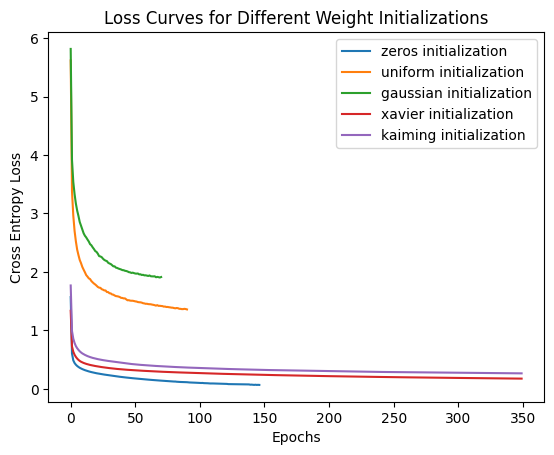

In [ ]:
# Experiment with different weight initializations
initializations = ["zeros", "uniform", "gaussian", "xavier", "kaiming"]
histories = {}
predictions = {}
accuracies = {}

for init in initializations:
    print(f"Training MLP with {init} initialization...")
    mlp = MLP(input_dim=784, hidden_layers=[128], activation_fn='relu', initialization=init)

    # Train the model
    mlp.fit(X_fashion_train, y_fashion_train, lr=0.0005, epochs=350, batch_size=64)

    # Store the loss history
    histories[init] = mlp.loss_history

    # Predict on the test set
    y_pred = mlp.predict(X_fashion_test)
    predictions[init] = y_pred

    # Evaluate and store the accuracy
    y_true = np.argmax(y_fashion_test, axis=0)
    acc = evaluate_acc(y_fashion_test, softmax(mlp._forward(X_fashion_test)[0][-1]))
    accuracies[init] = acc
    print(f"Accuracy for {init} initialization: {acc*100:.2f}%")

# Plot the loss histories
for init, history in histories.items():
    plt.plot(history, label=f"{init} initialization")

plt.title("Loss Curves for Different Weight Initializations")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy Loss")
plt.legend()
plt.show()

Experiment 2

In [ ]:
# Create different MLP architectures
model_configurations = {
    "no_hidden_layers": [],
    "one_hidden_layer": [128],
    "two_hidden_layers": [128, 128]
}

histories = {}
predictions = {}
accuracies = {}

for config_name, hidden_layers in model_configurations.items():
    print(f"Training MLP with configuration: {config_name}...")

    # Initialize the MLP model
    mlp = MLP(input_dim=784,
              hidden_layers=hidden_layers,
              activation_fn='relu',
              initialization="kaiming",
              use_bn=True)

    # Train the model
    mlp.fit(X_fashion_train, y_fashion_train, lr=0.0005, epochs=350, batch_size=64)

    # Store the loss history
    histories[config_name] = mlp.loss_history

    # Predict on the test set
    y_pred = mlp.predict(X_fashion_test)
    predictions[config_name] = y_pred

    # Evaluate and store the accuracy
    y_true = np.argmax(y_fashion_test, axis=0)
    acc = evaluate_acc(y_fashion_test, softmax(mlp._forward(X_fashion_test)[0][-1]))
    accuracies[config_name] = acc
    print(f"Accuracy for {config_name} configuration: {acc*100:.2f}%")

# Display accuracies for each configuration
for config_name, acc in accuracies.items():
    print(f"Test accuracy for {config_name}: {acc*100:.2f}%")


Training MLP with configuration: no_hidden_layers...
Early stopping due to increasing loss.
Accuracy for no_hidden_layers configuration: 81.23%
Training MLP with configuration: one_hidden_layer...
Accuracy for one_hidden_layer configuration: 84.99%
Training MLP with configuration: two_hidden_layers...
Accuracy for two_hidden_layers configuration: 87.95%
Test accuracy for no_hidden_layers: 81.23%
Test accuracy for one_hidden_layer: 84.99%
Test accuracy for two_hidden_layers: 87.95%


Experiment 3:

In [ ]:
# Create different MLP architectures with different activation functions
activation_functions = ["relu", "sigmoid", "tanh"]

histories = {}
predictions = {}
accuracies = {}

for activation in activation_functions:
    print(f"Training MLP with {activation} activation...")

    # Initialize the MLP model with 2 hidden layers and the specified activation function
    mlp = MLP(input_dim=784,
              hidden_layers=[128, 128],
              activation_fn=activation,
              initialization="kaiming",
              use_bn=True)

    # Train the model
    mlp.fit(X_fashion_train, y_fashion_train, lr=0.0005, epochs=350, batch_size=64)

    # Store the loss history
    histories[activation] = mlp.loss_history

    # Predict on the test set
    y_pred = mlp.predict(X_fashion_test)
    predictions[activation] = y_pred

    # Evaluate and store the accuracy
    y_true = np.argmax(y_fashion_test, axis=0)
    acc = evaluate_acc(y_fashion_test, softmax(mlp._forward(X_fashion_test)[0][-1]))
    accuracies[activation] = acc
    print(f"Accuracy for MLP with {activation} activation: {acc*100:.2f}%")

# Display accuracies for each activation function
for activation, acc in accuracies.items():
    print(f"Test accuracy for MLP with {activation} activation: {acc*100:.2f}%")


Training MLP with relu activation...
Accuracy for MLP with relu activation: 88.12%
Training MLP with sigmoid activation...
Accuracy for MLP with sigmoid activation: 84.79%
Training MLP with tanh activation...
Accuracy for MLP with tanh activation: 87.86%
Test accuracy for MLP with relu activation: 88.12%
Test accuracy for MLP with sigmoid activation: 84.79%
Test accuracy for MLP with tanh activation: 87.86%


Experiment 4:

In [ ]:
# L1 and L2 regularization strengths
regularization_strengths = {
    "no_regularization": {"lambda_l1": 0, "lambda_l2": 0},
    "l1_regularization": {"lambda_l1": 0.0001, "lambda_l2": 0},
    "l2_regularization": {"lambda_l1": 0, "lambda_l2": 0.0001},
    "l1_l2_regularization": {"lambda_l1": 0.0001, "lambda_l2": 0.0001}
}

histories = {}
predictions = {}
accuracies = {}

for reg_name, lambdas in regularization_strengths.items():
    print(f"Training MLP with {reg_name}...")

    # Initialize the MLP model with 2 hidden layers and ReLU activation
    mlp = MLP(input_dim=784,
              hidden_layers=[128, 128],
              activation_fn='relu',
              initialization="kaiming",
              use_bn=True)

    # Train the model
    mlp.fit(X_fashion_train, y_fashion_train, lr=0.0005, epochs=350, batch_size=64,
            lambda_l1=lambdas["lambda_l1"], lambda_l2=lambdas["lambda_l2"])

    # Store the loss history
    histories[reg_name] = mlp.loss_history

    # Predict on the test set
    y_pred = mlp.predict(X_fashion_test)
    predictions[reg_name] = y_pred

    # Evaluate and store the accuracy
    y_true = np.argmax(y_fashion_test, axis=0)
    acc = evaluate_acc(y_fashion_test, softmax(mlp._forward(X_fashion_test)[0][-1]))
    accuracies[reg_name] = acc
    print(f"Accuracy for MLP with {reg_name}: {acc*100:.2f}%")

# Display accuracies for each regularization type
for reg_name, acc in accuracies.items():
    print(f"Test accuracy for MLP with {reg_name}: {acc*100:.2f}%")

Training MLP with no_regularization...
Accuracy for MLP with no_regularization: 88.00%
Training MLP with l1_regularization...
Accuracy for MLP with l1_regularization: 88.26%
Training MLP with l2_regularization...
Accuracy for MLP with l2_regularization: 87.93%
Training MLP with l1_l2_regularization...
Accuracy for MLP with l1_l2_regularization: 88.10%
Test accuracy for MLP with no_regularization: 88.00%
Test accuracy for MLP with l1_regularization: 88.26%
Test accuracy for MLP with l2_regularization: 87.93%
Test accuracy for MLP with l1_l2_regularization: 88.10%


Experiment 5:

In [ ]:
# Load unnormalized Fashion MNIST dataset
fashion_mnist_train_unnorm = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
fashion_mnist_test_unnorm = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

X_fashion_unnorm = fashion_mnist_train_unnorm.data.numpy().reshape(-1, 28*28).T
y_fashion_unnorm = np.eye(10)[np.array(fashion_mnist_train_unnorm.targets)].T
X_fashion_train_unnorm, y_fashion_train_unnorm, X_fashion_test_unnorm, y_fashion_test_unnorm = train_test_split(X_fashion_unnorm, y_fashion_unnorm)

# Initialize the MLP model with 2 hidden layers and ReLU activation
mlp_unnorm = MLP(input_dim=784,
                 hidden_layers=[128, 128],
                 activation_fn='relu',
                 initialization="kaiming",
                 use_bn=True)

# Initialize the MLP model with 2 hidden layers and ReLU activation
mlp_norm = MLP(input_dim=784,
                 hidden_layers=[128, 128],
                 activation_fn='relu',
                 initialization="kaiming",
                 use_bn=True)

# Train the model with unnormalized data
mlp_unnorm.fit(X_fashion_train_unnorm, y_fashion_train_unnorm, lr=0.0005, epochs=350, batch_size=64)

# Predict on the test set
y_pred_unnorm = mlp_unnorm.predict(X_fashion_test_unnorm)

# Evaluate the accuracy
y_true_unnorm = np.argmax(y_fashion_test_unnorm, axis=0)
acc_unnorm = evaluate_acc(y_fashion_test_unnorm, softmax(mlp_unnorm._forward(X_fashion_test_unnorm)[0][-1]))

# Train the model with normalized data
mlp_norm.fit(X_fashion_train, y_fashion_train, lr=0.0005, epochs=350, batch_size=64)

# Predict on the test set
y_pred_norm = mlp_norm.predict(X_fashion_test)

# Evaluate the accuracy
y_true_norm = np.argmax(y_fashion_test, axis=0)
acc_norm = evaluate_acc(y_fashion_test, softmax(mlp_norm._forward(X_fashion_test)[0][-1]))

print(f"Test accuracy for MLP trained with unnormalized data: {acc_unnorm*100:.2f}%")
print(f"Test accuracy for MLP trained with normalized data: {acc_norm*100:.2f}%")

Test accuracy for MLP trained with unnormalized data: 87.98%
Test accuracy for MLP trained with normalized data: 88.17%


Experiment 6:

In [15]:
# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self,
                input_channels=1, input_size=28,
                num_filters1=32, kernel_size1=3, stride1=1, padding1=1,
                num_filters2=64, kernel_size2=3, stride2=1, padding2=1):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(input_channels, num_filters1, kernel_size=kernel_size1, stride=stride1, padding=padding1)
        self.conv2 = nn.Conv2d(num_filters1, num_filters2, kernel_size=kernel_size2, stride=stride2, padding=padding2)

        # Calculate output size after conv layers
        output_size1 = ((input_size - kernel_size1 + 2*padding1) // stride1 + 1) // 2
        output_size2 = ((output_size1 - kernel_size2 + 2*padding2) // stride2 + 1) // 2
        fc_input_size = num_filters2 * output_size2 * output_size2

        # Fully connected layers
        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 10)

        # Activation and pooling
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.max_pool(x)

        x = self.relu(self.conv2(x))
        x = self.max_pool(x)

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Test Accuracy of the CNN on Fashion MNIST: 91.20%


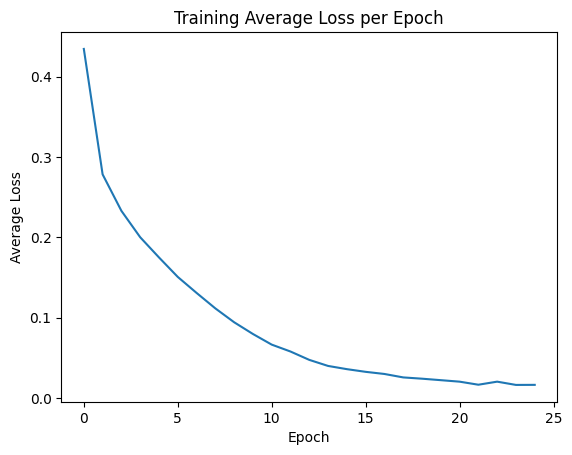

In [16]:
# Initialize the CNN model for grayscale images, loss, and optimizer
model = CNN(input_channels=1, input_size=28)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Prepare DataLoader for Fashion MNIST
train_loader = torch.utils.data.DataLoader(fashion_mnist_train, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(fashion_mnist_test, batch_size=64, shuffle=False)

avg_loss_history = []

# Train the model
for epoch in range(25):
    epoch_loss = 0
    num_batches = 0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        epoch_loss += loss.item()
        num_batches += 1

        loss.backward()
        optimizer.step()

    # Compute average loss for the epoch
    avg_loss = epoch_loss / num_batches
    avg_loss_history.append(avg_loss)

# Evaluate the accuracy on test set
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy of the CNN on Fashion MNIST: {100 * correct / total:.2f}%')

# Plotting the average loss per epoch
plt.plot(avg_loss_history)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Training Average Loss per Epoch')
plt.show()

Experiment 7:

In [ ]:
# MLP for CIFAR-10
mlp_cifar = MLP(input_dim=32*32*3,
                hidden_layers=[1024, 512, 256],
                activation_fn='relu',
                initialization="kaiming",
                use_bn=True)

mlp_cifar.fit(X_cifar_train, y_cifar_train,
              lr=0.0005, epochs=350, batch_size=64,
              lambda_l1=0.00001, lambda_l2=0.00001,
              noise_level=0.0, dropout_rate=0.25,
              decay_rate=0.0001)

# Prediction with MLP
y_pred_mlp_cifar = mlp_cifar.predict(X_cifar_test)

# Evaluate the accuracy for MLP
y_true_cifar = np.argmax(y_cifar_test, axis=0)
acc_mlp_cifar = evaluate_acc(y_cifar_test, softmax(mlp_cifar._forward(X_cifar_test)[0][-1]))
print(f"Test accuracy for MLP on CIFAR-10: {acc_mlp_cifar*100:.2f}%")

# Prepare DataLoader for CIFAR-10
cifar_train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=64, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=False)

# Initialize the CNN model for RGB images, loss, and optimizer for CIFAR-10
cnn_cifar = CNN(input_channels=3, input_size=32)
criterion_cifar = nn.CrossEntropyLoss()
optimizer_cifar = optim.Adam(cnn_cifar.parameters(), lr=0.001)

# Train the CNN model on CIFAR-10
for epoch in range(25):  # Number of epochs can be adjusted
    for i, (images, labels) in enumerate(cifar_train_loader):
        optimizer_cifar.zero_grad()

        outputs = cnn_cifar(images)
        loss = criterion_cifar(outputs, labels)
        loss.backward()
        optimizer_cifar.step()

# Evaluate the accuracy of the CNN on CIFAR-10 test data
correct_cnn = 0
total_cnn = 0
with torch.no_grad():
    for images, labels in cifar_test_loader:
        outputs = cnn_cifar(images)
        _, predicted = torch.max(outputs.data, 1)
        total_cnn += labels.size(0)
        correct_cnn += (predicted == labels).sum().item()

print(f'Test Accuracy of the CNN on CIFAR-10: {100 * correct_cnn / total_cnn:.2f}%')

Test accuracy for MLP on CIFAR-10: 50.80%
Test Accuracy of the CNN on CIFAR-10: 71.09%


Experiment 8:

In [19]:
def train_model(model, criterion, optimizer, train_loader, epochs):
    for epoch in range(epochs):
        for i, (images, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate_model(model, test_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [ ]:
momentums = [0, 0.2, 0.4, 0.6, 0.8, 0.9]

criterion = nn.CrossEntropyLoss()

for momentum in momentums:
    model_sgd = CNN(input_channels=3, input_size=32)
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.001, momentum=momentum)

    train_model(model_sgd, criterion, optimizer_sgd, cifar_train_loader, epochs=10)
    acc_sgd = evaluate_model(model_sgd, cifar_test_loader)

    print(f'Test Accuracy with SGD (momentum={momentum}): {acc_sgd:.2f}%')

model_adam = CNN(input_channels=3, input_size = 32)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)

train_model(model_adam, criterion, optimizer_adam, cifar_train_loader, epochs=25)
acc_adam = evaluate_model(model_adam, cifar_test_loader)

print(f'Test Accuracy with Adam: {acc_adam:.2f}%')

Test Accuracy with SGD (momentum=0): 38.47%
Test Accuracy with SGD (momentum=0.2): 41.88%
Test Accuracy with SGD (momentum=0.4): 44.04%
Test Accuracy with SGD (momentum=0.6): 49.75%
Test Accuracy with SGD (momentum=0.8): 56.29%
Test Accuracy with SGD (momentum=0.9): 63.53%
Test Accuracy with Adam: 69.70%


Experiment 9:

In [27]:
model = models.resnet18(pretrained=True)

# Freeze all convolutional layers
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features

fc_layers = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

model.fc = fc_layers

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

start_time = time.time()
train_model(model, criterion, optimizer, cifar_train_loader, epochs=10)
end_time = time.time()

acc = evaluate_model(model, cifar_test_loader)
print(f'Test Accuracy with pre-trained ResNet-18: {acc:.2f}%')
print(f"Training time: {end_time - start_time:.2f} seconds")

Test Accuracy with pre-trained ResNet-18: 44.48%
Training time: 564.72 seconds


Bonus Experiment: Effect of MLP Width

Training MLP with hidden layer width: 32
Test Accuracy with hidden layer width 32: 30.53%

Training MLP with hidden layer width: 64
Test Accuracy with hidden layer width 64: 72.07%

Training MLP with hidden layer width: 128
Test Accuracy with hidden layer width 128: 76.18%

Training MLP with hidden layer width: 256
Test Accuracy with hidden layer width 256: 81.23%

Training MLP with hidden layer width: 512
Test Accuracy with hidden layer width 512: 82.04%

Training MLP with hidden layer width: 1024
Test Accuracy with hidden layer width 1024: 83.36%



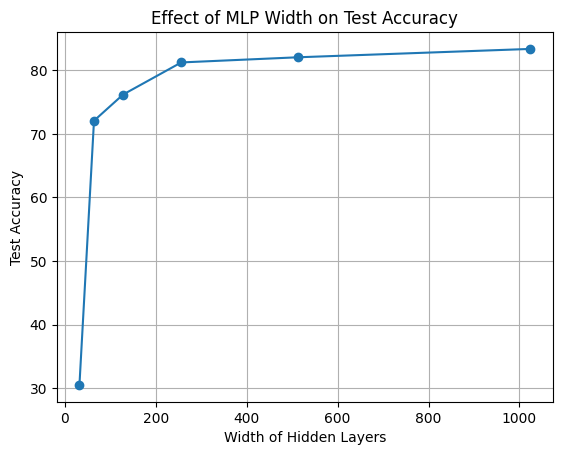

In [ ]:
def evaluate_mlp_width(widths, X_train, y_train, X_test, y_test, epochs=10):
    accuracies = []

    for width in widths:
        print(f"Training MLP with hidden layer width: {width}")
        mlp = MLP(input_dim=X_train.shape[0], hidden_layers=[width], activation_fn='relu', initialization="kaiming")

        # Train the MLP
        mlp.fit(X_train, y_train, lr=0.0005, epochs=epochs, batch_size=64)

        # Predict on test set
        y_pred = mlp.predict(X_test)
        y_true = np.argmax(y_test, axis=0)

        # Calculate accuracy
        acc = np.mean(y_true == y_pred)*100
        accuracies.append(acc)
        print(f"Test Accuracy with hidden layer width {width}: {acc:.2f}%\n")

    return accuracies

widths = [32, 64, 128, 256, 512, 1024]
accuracies = evaluate_mlp_width(widths, X_fashion_train, y_fashion_train, X_fashion_test, y_fashion_test)

import matplotlib.pyplot as plt

plt.plot(widths, accuracies, marker='o')
plt.xlabel('Width of Hidden Layers')
plt.ylabel('Test Accuracy')
plt.title('Effect of MLP Width on Test Accuracy')
plt.grid(True)
plt.show()

Bonus Experiment: Effect of MLP Depth

Training MLP with depth: 1
Test Accuracy with depth 1: 76.77%

Training MLP with depth: 2
Test Accuracy with depth 2: 73.93%

Training MLP with depth: 3
Test Accuracy with depth 3: 78.94%

Training MLP with depth: 4
Test Accuracy with depth 4: 80.55%

Training MLP with depth: 5
Test Accuracy with depth 5: 81.88%

Training MLP with depth: 6
Test Accuracy with depth 6: 80.09%



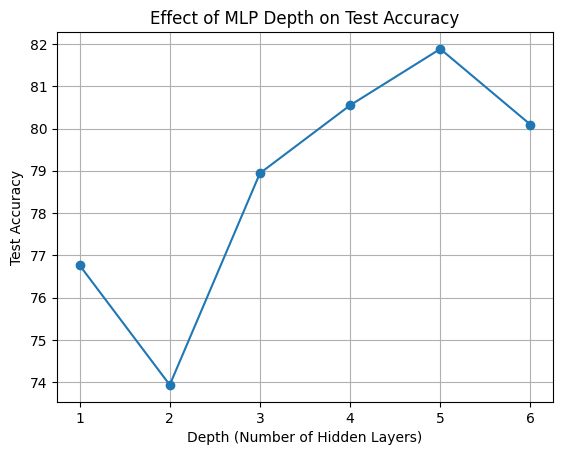

In [ ]:
def evaluate_mlp_depth(depths, X_train, y_train, X_test, y_test, width=128, epochs=10):
    accuracies = []

    for depth in depths:
        print(f"Training MLP with depth: {depth}")

        # Create a list defining the architecture with specified depth and width
        hidden_layers = [width] * depth
        mlp = MLP(input_dim=X_train.shape[0], hidden_layers=hidden_layers, activation_fn='relu', initialization="kaiming")

        # Train the MLP
        mlp.fit(X_train, y_train, lr=0.0005, epochs=epochs, batch_size=64)

        # Predict on test set
        y_pred = mlp.predict(X_test)
        y_true = np.argmax(y_test, axis=0)

        # Calculate accuracy
        acc = np.mean(y_true == y_pred)*100
        accuracies.append(acc)
        print(f"Test Accuracy with depth {depth}: {acc:.2f}%\n")

    return accuracies

depths = [1, 2, 3, 4, 5, 6]
accuracies_depth = evaluate_mlp_depth(depths, X_fashion_train, y_fashion_train, X_fashion_test, y_fashion_test)

plt.plot(depths, accuracies_depth, marker='o')
plt.xlabel('Depth (Number of Hidden Layers)')
plt.ylabel('Test Accuracy')
plt.title('Effect of MLP Depth on Test Accuracy')
plt.grid(True)
plt.show()

Bonus Experiment: Effect on Batch Normalization

Training an MLP without batch normalization


<ipython-input-5-f2648e1ed052>:19: RuntimeWarning: overflow encountered in exp
  s = 1.0 / (1.0 + np.exp(-z))


Early stopping due to increasing loss.
[8 8 7 ... 8 8 6]
Accuracy: 0.8154166666666667

Training an MLP with batch normalization
[8 8 7 ... 8 8 9]
Accuracy: 0.873



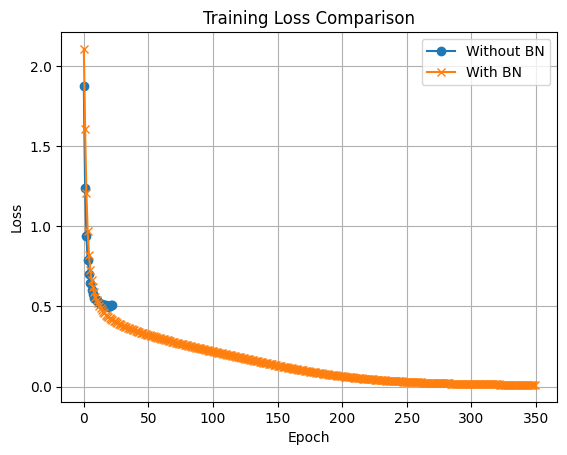

In [ ]:
print("Training an MLP without batch normalization")
# 2. Train an MLP without batch normalization
mlp_no_bn = MLP(input_dim=784, hidden_layers=[128, 64], activation_fn='sigmoid', initialization='xavier')
mlp_no_bn.fit(X_fashion_train, y_fashion_train, epochs=350, lr=0.01)
loss_no_bn = mlp_no_bn.loss_history

# Testing prediction
y_pred = mlp_no_bn.predict(X_fashion_test)
print(y_pred)

# Testing evaluation metrics
y_true_sample = y_fashion_test
metrics = evaluate_metrics(np.argmax(y_true_sample, axis=0), y_pred)
acc = evaluate_acc(y_true_sample, softmax(mlp_no_bn._forward(X_fashion_test)[0][-1]))
print(f"Accuracy: {acc}")
print("")

print("Training an MLP with batch normalization")
# 3. Train an MLP with batch normalization
mlp_bn = MLP(input_dim=784, hidden_layers=[128, 64], activation_fn='sigmoid', initialization='xavier', use_bn=True)
mlp_bn.fit(X_fashion_train, y_fashion_train, epochs=350, lr=0.01)
loss_bn = mlp_bn.loss_history

# Testing prediction
y_pred = mlp_bn.predict(X_fashion_test)
print(y_pred)

# Testing evaluation metrics
y_true_sample = y_fashion_test
metrics = evaluate_metrics(np.argmax(y_true_sample, axis=0), y_pred)
acc = evaluate_acc(y_true_sample, softmax(mlp_bn._forward(X_fashion_test)[0][-1]))
print(f"Accuracy: {acc}")
print("")

# 4. Compare the training loss
plt.plot(loss_no_bn, label='Without BN', marker='o')
plt.plot(loss_bn, label='With BN', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Comparison')
plt.grid(True)
plt.show()

Bonus Experiment: Effect of CNN Convolutional Layer Hyperparameters

In [17]:
# List of hyperparameters
hyperparameters = [
    {"num_filters": 16, "kernel_size": 3, "stride": 1, "padding": 1},
    {"num_filters": 32, "kernel_size": 3, "stride": 1, "padding": 1},
    {"num_filters": 16, "kernel_size": 5, "stride": 1, "padding": 2},
    {"num_filters": 16, "kernel_size": 3, "stride": 2, "padding": 1},
]

# Prepare DataLoader for CIFAR-10
cifar_train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=64, shuffle=True)
cifar_test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=64, shuffle=False)

# Define the experiment function
def run_experiment(hyperparameters, train_loader, test_loader, epochs=25):
    results = []

    for params in hyperparameters:
        # Initialize the CNN model with given hyperparameters
        model = CNN(
            input_channels=3,
            input_size=32,
            num_filters1=params["num_filters"],
            kernel_size1=params["kernel_size"],
            stride1=params["stride"],
            padding1=params["padding"],
            num_filters2=64,  # Keeping this constant for simplicity
            kernel_size2=3, stride2=1, padding2=1  # Keeping these constant for simplicity
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train the model
        for epoch in range(epochs):
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # Evaluate the model on test set
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        results.append({"hyperparameters": params, "accuracy": accuracy})

    return results

# Assuming cifar10_train and cifar10_test are already loaded
results = run_experiment(hyperparameters, cifar_train_loader, cifar_test_loader)

def print_results(results):
    print("Experiment Results:")
    print("--------------------")
    for entry in results:
        params = entry["hyperparameters"]
        accuracy = entry["accuracy"]
        print(f"Hyperparameters: num_filters={params['num_filters']}, kernel_size={params['kernel_size']}, stride={params['stride']}, padding={params['padding']}")
        print(f"Accuracy: {accuracy:.2f}%")
        print("--------------------")

print_results(results)

Experiment Results:
--------------------
Hyperparameters: num_filters=16, kernel_size=3, stride=1, padding=1
Accuracy: 69.70%
--------------------
Hyperparameters: num_filters=32, kernel_size=3, stride=1, padding=1
Accuracy: 70.54%
--------------------
Hyperparameters: num_filters=16, kernel_size=5, stride=1, padding=2
Accuracy: 68.65%
--------------------
Hyperparameters: num_filters=16, kernel_size=3, stride=2, padding=1
Accuracy: 66.97%
--------------------
